In [1]:
import torch

In [2]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cie5h040
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cie5h040
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6c90fb2f76f8f45576b69249e4dd48a38c022e8d7c8b4de817c0d2f841185a4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2gt2t8w/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-17 13:34:21--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [ ]:
pip install torch torchvision segment-anything shapely scikit-learn matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import cv2
import urllib.request
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# **Exemple PIE implémentation sur 1 image**

Voici une première version du PIE, testée sur une seule image.

Actuellement, l’EAC détecte principalement les oreilles du chien ainsi qu’une partie de la gamelle, qui semblent être les concepts les plus importants. Mais, je pense que ce résultat peut être nettement amélioré. Par manque de ressources, j’ai pas pu tester autant de coalitions que dans l’article original (1 000 contre 50 000), ce qui limite la qualité des explications générées.

Pour reproduire la suite du papier, il faut retrouver les résultats de faithfulness, understability et ablation study.
Pour ceci, il faudrait :
- Obtenir de meilleurs résultats explicatifs sur une image individuelle.

- Implémenter un code d’évaluation de l’AUC via les méthodes d’insertion et de suppression (insertion/deletion scheme).

- Évaluer le modèle sur un ensemble plus large d’images provenant d’ImageNet et COCO.

- Mesurer la compréhensibilité des masques générés auprès de 6 annotateurs humains.

- Noter et analyser le temps de traitement pour chaque étape.

**Phase 1 : Concept Discovery**

Etape 1-2 : Charger l'image et la segmenter avec SAM

In [6]:
bus = cv2.imread('images/bus.png')
bus = cv2.cvtColor(bus, cv2.COLOR_BGR2RGB)

train = cv2.imread('images/train.png')
train = cv2.cvtColor(train, cv2.COLOR_BGR2RGB)

kitesurf = cv2.imread('images/kitesurf.png')
kitesurf = cv2.cvtColor(kitesurf, cv2.COLOR_BGR2RGB)

zebra = cv2.imread('images/zebra.png')
zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)

images = [bus, train, kitesurf, zebra]

In [7]:
# === Segmenter avec SAM ===
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = []
for image in images:
  masks.append(mask_generator.generate(image))

In [9]:
for i, mask_list in enumerate(masks):
    print(f"Image {i} → {len(mask_list)} concepts")

Image 0 → 72 concepts
Image 1 → 100 concepts
Image 2 → 31 concepts
Image 3 → 33 concepts


Vérifier la segmentation de SAM

In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

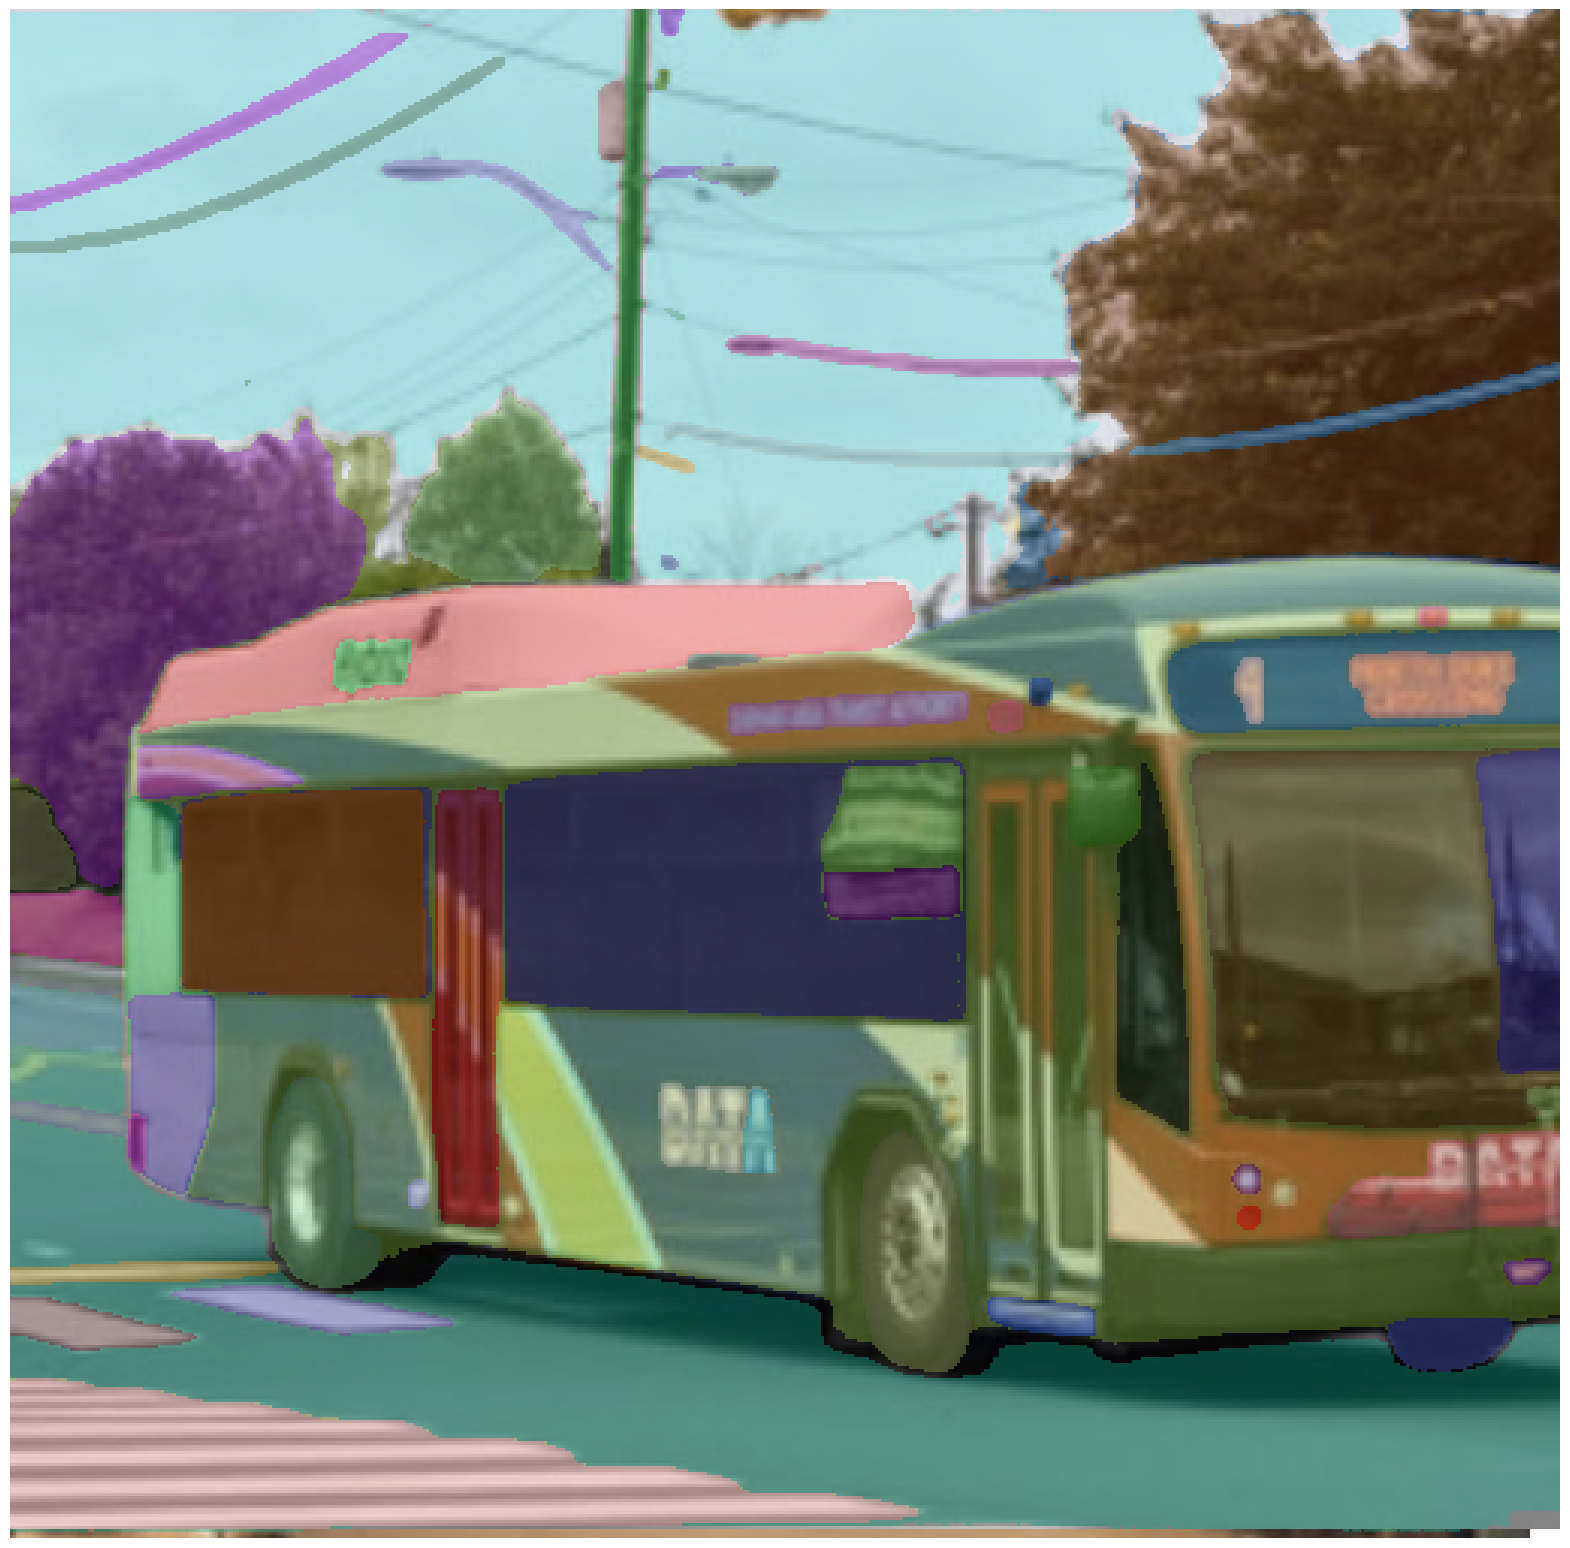

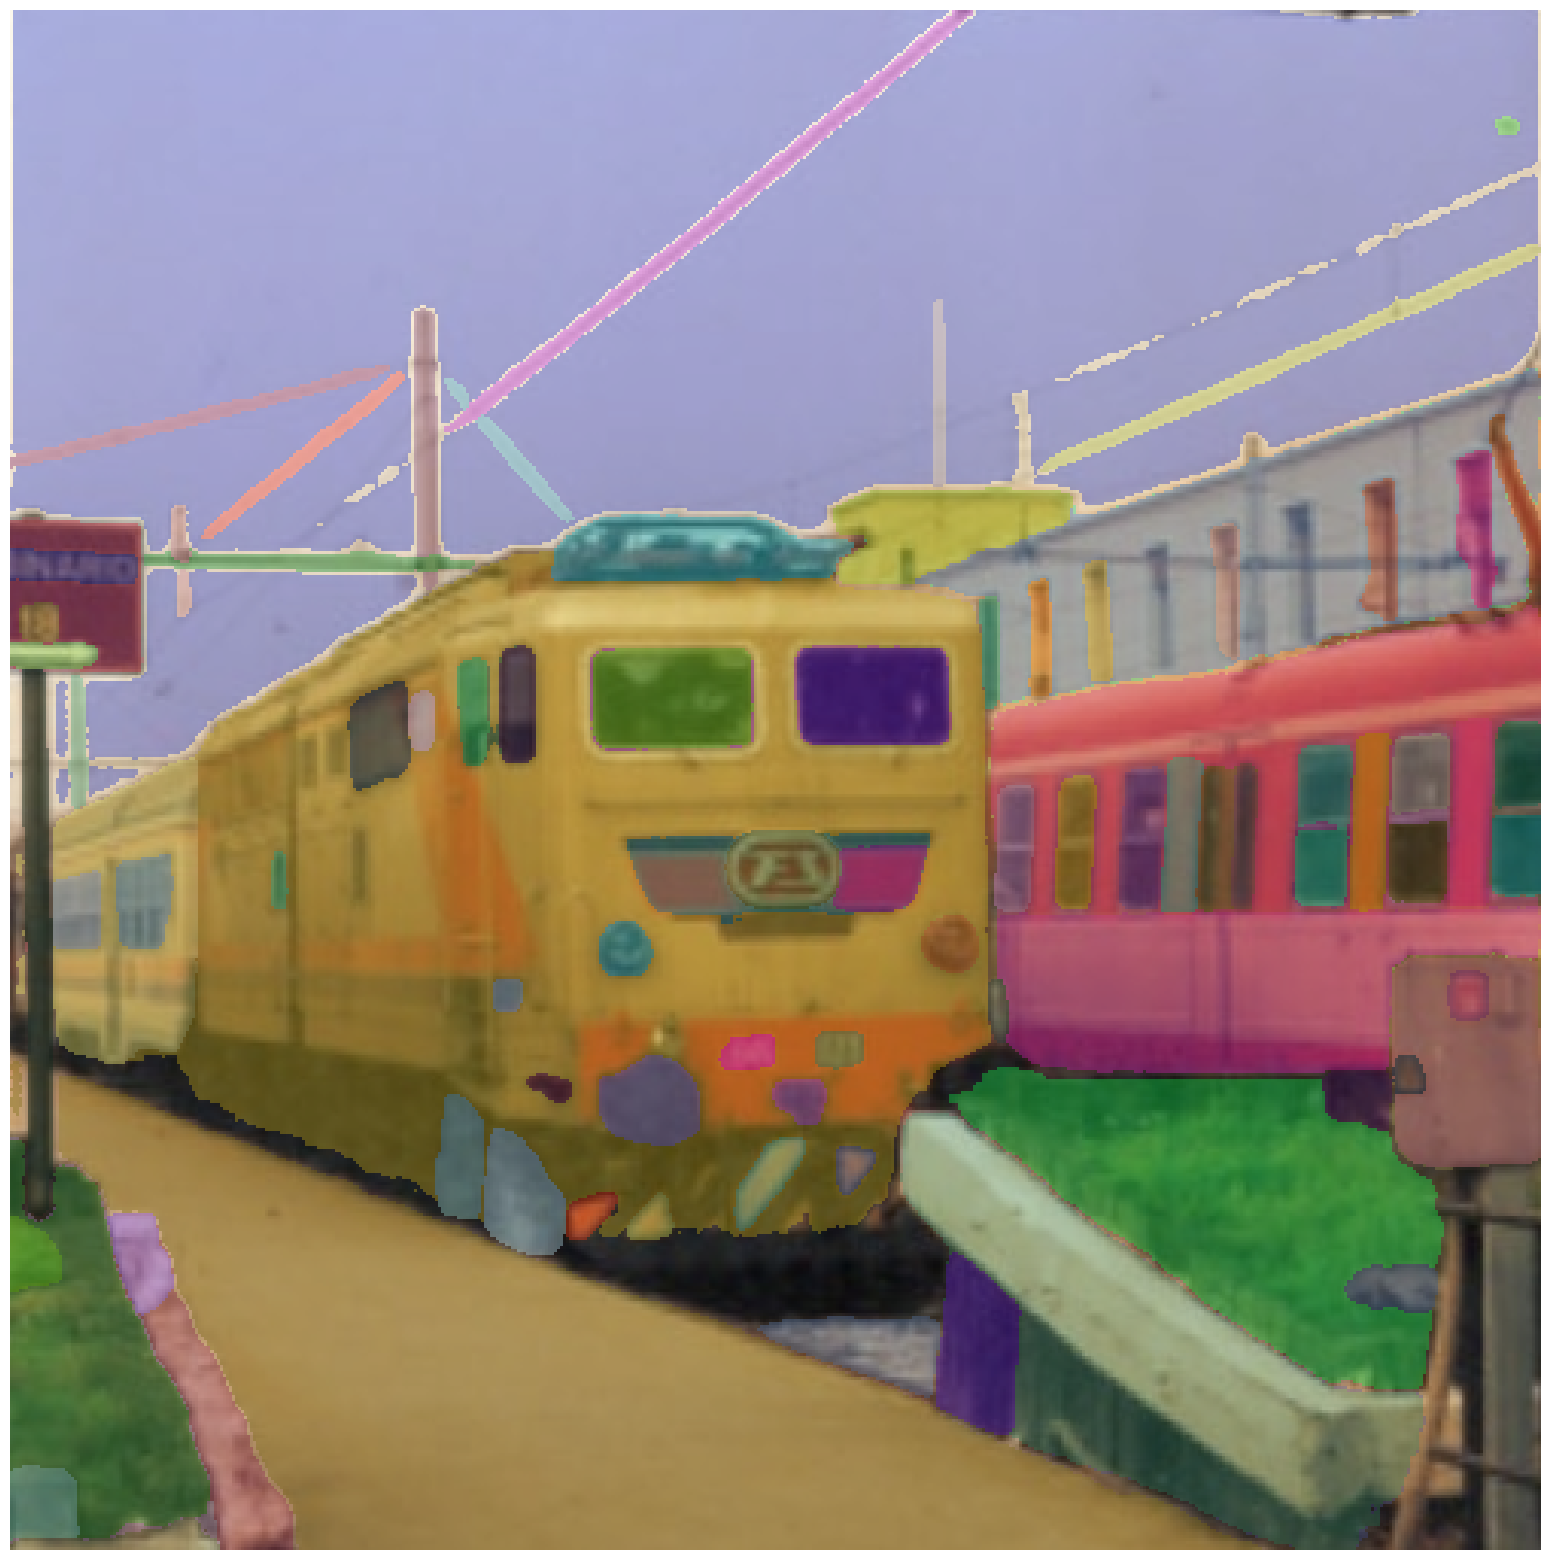

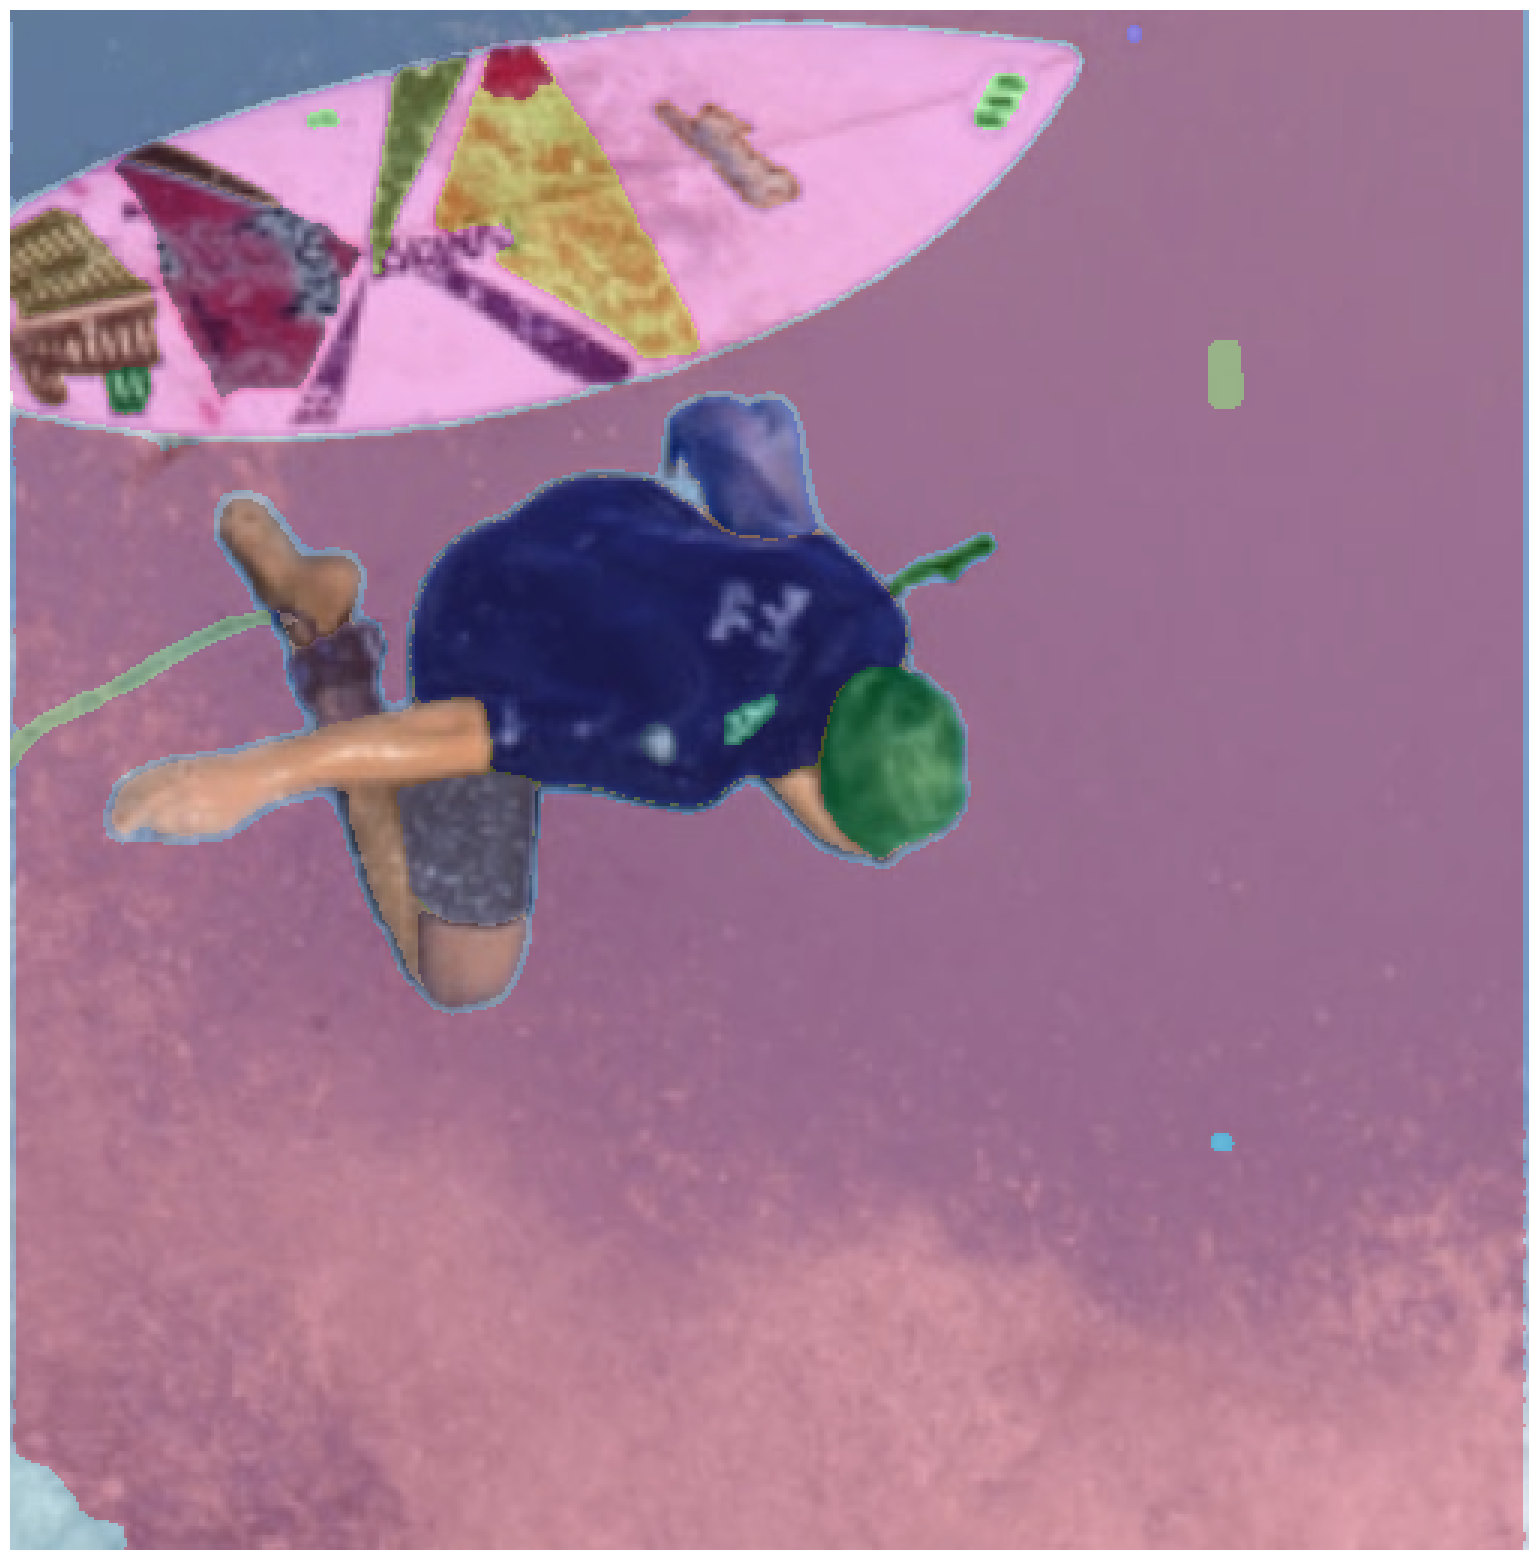

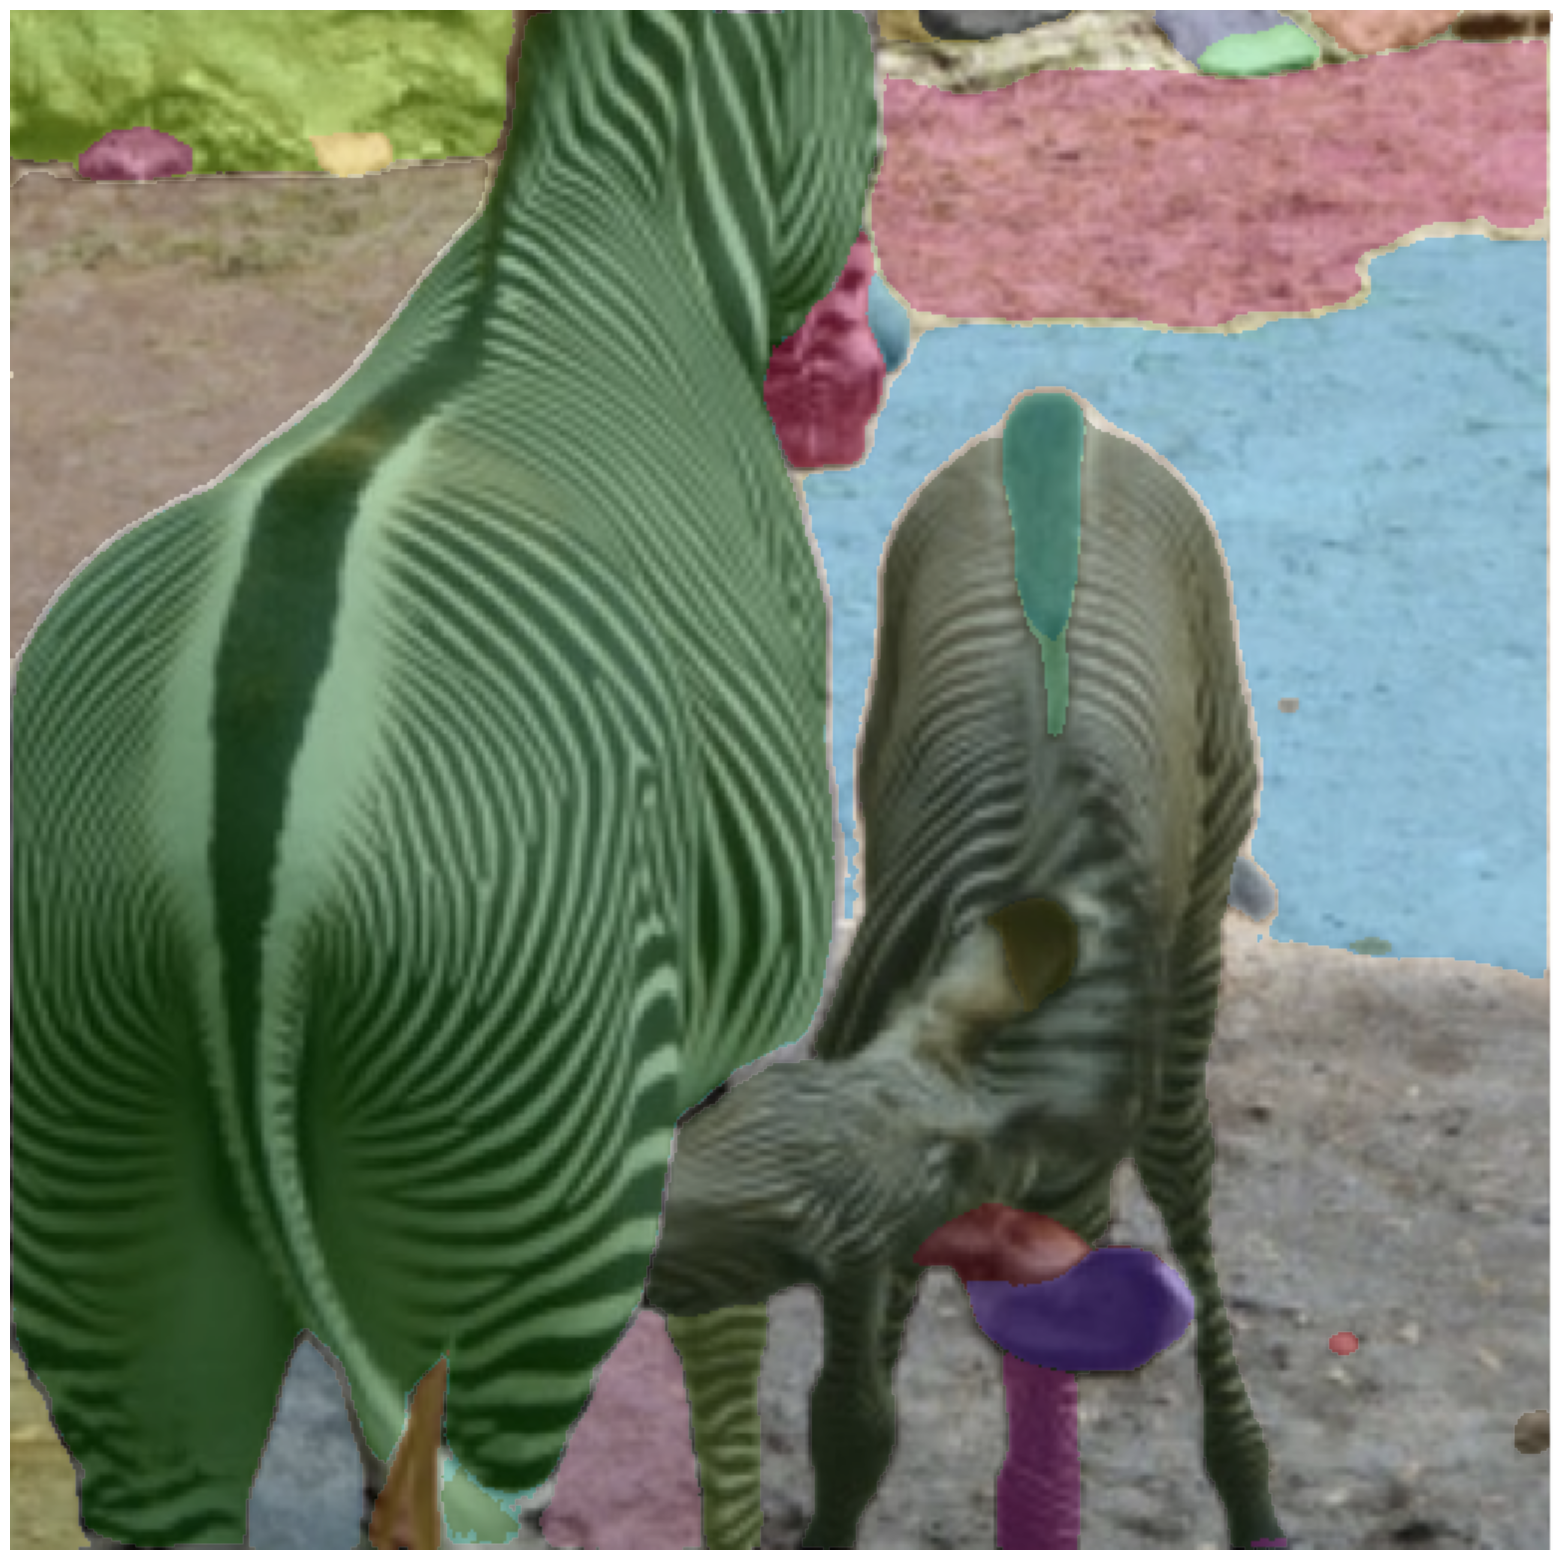

In [11]:
for image, mask in zip(images, masks):
  plt.figure(figsize=(20,20))
  plt.imshow(image)
  show_anns(mask)
  plt.axis('off')
  plt.show()

**Phase 2 : PIE**

Etape 3 : Charger modèle target : Resnet-50 pré-entrainé sur ImageNet

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor

target_model = models.resnet50(weights='IMAGENET1K_V2')
target_model.eval()
target_model = target_model.to("cuda")
fc_layer = target_model.fc
#feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # sans FC

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


Tester prédiction du Resnet-50

In [13]:
# Normalisation ImageNet (moyennes et std pour RGB)
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
)

In [14]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import urllib

def get_predicted_classes(images_np, model, device="cuda", target_size=(224, 224)):
    """
    Prédit les classes pour une liste d'images numpy (HWC), redimensionnées à target_size.
    Affiche les noms de classes prédits.
    Retourne la liste des indices prédits.
    """
    # Charger les noms de classes ImageNet (s'ils ne sont pas déjà en cache)
    imagenet_classes_path = "imagenet_classes.txt"
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        imagenet_classes_path
    )
    with open(imagenet_classes_path) as f:
        class_names = [line.strip() for line in f.readlines()]

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),  # convertit en [0,1] et [C,H,W]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    tensors = []
    for i, img in enumerate(images_np):
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)  # Assure format image
            img_tensor = preprocess(img)
            tensors.append(img_tensor)
        else:
            raise ValueError("Chaque image doit être un tableau numpy (H,W,C)")

    batch = torch.stack(tensors).to(device)

    with torch.no_grad():
        logits = model(batch)
        predicted_indices = torch.argmax(logits, dim=1)

    # Affichage des noms
    for i, idx in enumerate(predicted_indices):
        print(f"Image {i} → classe prédite : {idx.item()} → {class_names[idx]}")

    return predicted_indices


In [15]:
# images_np = [img1, img2, img3, ...] (liste de tableaux numpy HWC)
predicted_indices = get_predicted_classes(images_np=images, model=target_model)
print("Liste des classes prédites : ", predicted_indices.tolist())  # ou convertis en noms si besoin

Image 0 → classe prédite : 874 → trolleybus
Image 1 → classe prédite : 547 → electric locomotive
Image 2 → classe prédite : 701 → parachute
Image 3 → classe prédite : 340 → zebra
Liste des classes prédites :  [874, 547, 701, 340]


On remarque sur le Resnet ne prédit pas correctement l'image 2 et 3 et prédit passenger car et parachute pour des images de bus et kitesurf.

Etape 3 : Mettre en place le Surrogate modèle

Dans le papier précise que c'est 1 surrogate pour chcune des images.

In [16]:
import torch.optim as optim

class SurrogateModel(torch.nn.Module):
    def __init__(self, fc_layer, num_concepts, feature_dim=2048, lr=0.008):
        super().__init__()
        self.h = torch.nn.Sequential(
            torch.nn.Linear(num_concepts, feature_dim)
        )
        self.fc = fc_layer  # partagé avec ResNet

        # Freeze les paramètres
        for param in self.fc.parameters():
          param.requires_grad = False
        self.loss = torch.nn.BCELoss()

        self.optimizer = optim.SGD(self.h.parameters(), lr=lr, momentum=0.9)

    def forward(self, b_onehot):
        features = self.h(b_onehot)
        return self.fc(features)

surrogates = []
for mask in masks:
    num_concepts = len(mask)
    surrogates.append(SurrogateModel(fc_layer, num_concepts).to("cuda"))

In [17]:
for surrogate in surrogates:
  print(surrogate)

SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=72, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=31, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=33, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)


Etape 5 : Créer le dataset d'entrainement du surrogate model = (image dont  certains concepts masqués, prédiction label du target model avec cette image masquée)

In [17]:
import torchvision.transforms as transforms

# === créer les coalitions d’entraînement ===
def mask_image_from_concepts(concepts, concept_mask, image):
    """
    Masque l'image en gardant uniquement les concepts activés dans concept_mask.
    Le masquage est fait par multiplication, pas par remplacement par zéro direct.

    Args:
        concepts (list of np.array): Liste de masques booléens (H x W) pour chaque concept.
        concept_mask (np.array): Vecteur binaire de sélection des concepts (taille = nb concepts).
        image (np.array): Image RGB originale (H x W x 3), dtype uint8.

    Returns:
        masked_img_tensor (torch.Tensor): Image masquée, normalisée, shape [1, 3, H, W].
    """

    # Initialiser un masque combiné float 2D (H x W) à 0
    mask_combined = np.zeros(image.shape[:2], dtype=float)

    for i, mask in enumerate(concepts):
        if concept_mask[i]:
            # Ajouter la région du concept (mask binaire converti en float)
            mask_combined += mask.astype(float)

    # Clamp pour ne pas dépasser 1 (en cas de chevauchement)
    mask_combined = np.clip(mask_combined, 0, 1)

    # Étendre mask_combined sur les 3 canaux (H x W -> H x W x 3)
    mask_combined_3ch = np.repeat(mask_combined[:, :, np.newaxis], 3, axis=2)

    # Multiplier pixel-wise (float multiplication)
    masked_img = image.astype(float) * mask_combined_3ch

    # Remettre au format uint8
    masked_img = masked_img.astype(np.uint8)

    # Convertir en tensor, permuter (H, W, C) -> (C, H, W) et normaliser
    masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1).float() / 255.
    masked_img_tensor = normalize(masked_img_tensor)
    masked_img_tensor = masked_img_tensor.unsqueeze(0)  # batch dimension

    return masked_img_tensor


In [18]:
datasets = {}  # Pour stocker les datasets par image
num_samples = 2500

for img_idx, (image, mask, predicted_index) in enumerate(zip(images, masks, predicted_indices)):
    samples = []
    labels = []

    concepts = [mask["segmentation"] for mask in masks[img_idx]]  # si masks est une liste de listes (par image)
    num_concepts = len(mask)

    for _ in range(num_samples):
        mask_bin = np.random.randint(0, 2, size=(num_concepts,))
        x_masked = mask_image_from_concepts(concepts, mask_bin, image)

        with torch.no_grad():
            out = target_model(x_masked.to("cuda"))
            probs = torch.nn.functional.softmax(out, dim=1)
            prob_target = probs[:, predicted_index]
            labels.append(prob_target.item())

        samples.append(torch.FloatTensor(mask_bin))

    samples_tensor = torch.stack(samples).to("cuda")
    labels_tensor = torch.tensor(labels).float().to("cuda")

    # Stocker dans un dict, ou liste si tu préfères
    datasets[f"image_{img_idx}"] = (samples_tensor, labels_tensor)

In [19]:
print(f"Nombre d’images dans datasets: {len(datasets)}")
for key, (samples_t, labels_t) in datasets.items():
    print(f"{key}: samples {samples_t.shape}, labels {labels_t.shape}")
    print(f"Exemple samples[0]: {samples_t[0]}")
    print(f"Shape samples: {samples_t.shape}")
    print(f"Exemple labels[0]: {labels_t[0]}")
    print(f"Shape labels: {labels_t.shape}")
    break

Nombre d’images dans datasets: 4
image_0: samples torch.Size([2500, 72]), labels torch.Size([2500])
Exemple samples[0]: tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
Shape samples: torch.Size([2500, 72])
Exemple labels[0]: 0.009855864569544792
Shape labels: torch.Size([2500])


Etape 6 : Train surrogate model with the dataset

In [20]:
num_epochs = 200

for img_idx, surrogate in enumerate(surrogates):
    print(f"\n=== Entraînement surrogate pour image {img_idx} ===")

    samples_tensor, labels_tensor = datasets[f"image_{img_idx}"]

    for epoch in range(num_epochs):
        surrogate.train()

        # Forward pass : prédire probabilité de la classe cible
        pred = torch.nn.functional.softmax(surrogate(samples_tensor), dim=1)[:, predicted_indices[img_idx]]

        # Calcul de la perte BCE entre prédiction et vérité
        loss = surrogate.loss(pred, labels_tensor)

        # Backpropagation
        surrogate.optimizer.zero_grad()
        loss.backward()
        surrogate.optimizer.step()

        if epoch % 20 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")



=== Entraînement surrogate pour image 0 ===
Epoch 000 | Loss: 0.1168
Epoch 020 | Loss: 0.1061
Epoch 040 | Loss: 0.0911
Epoch 060 | Loss: 0.0813
Epoch 080 | Loss: 0.0789
Epoch 100 | Loss: 0.0788
Epoch 120 | Loss: 0.0786
Epoch 140 | Loss: 0.0785
Epoch 160 | Loss: 0.0784
Epoch 180 | Loss: 0.0783
Epoch 199 | Loss: 0.0782

=== Entraînement surrogate pour image 1 ===
Epoch 000 | Loss: 0.0629
Epoch 020 | Loss: 0.0594
Epoch 040 | Loss: 0.0543
Epoch 060 | Loss: 0.0502
Epoch 080 | Loss: 0.0477
Epoch 100 | Loss: 0.0467
Epoch 120 | Loss: 0.0464
Epoch 140 | Loss: 0.0464
Epoch 160 | Loss: 0.0464
Epoch 180 | Loss: 0.0464
Epoch 199 | Loss: 0.0463

=== Entraînement surrogate pour image 2 ===
Epoch 000 | Loss: 0.0293
Epoch 020 | Loss: 0.0290
Epoch 040 | Loss: 0.0286
Epoch 060 | Loss: 0.0282
Epoch 080 | Loss: 0.0278
Epoch 100 | Loss: 0.0275
Epoch 120 | Loss: 0.0272
Epoch 140 | Loss: 0.0269
Epoch 160 | Loss: 0.0267
Epoch 180 | Loss: 0.0264
Epoch 199 | Loss: 0.0263

=== Entraînement surrogate pour image 3

**Phase 3 : Concept based Explanation**

On utilise le PIE à la place du target modèl pour estimer les shapley values

Pour chaque concept calcule sa contribution : Monte Carlo sampling de coalitions

DANS PAPIER K = 50 000. Consomme trop de ressources, j'arrive pas à faire tourner sur GPU.

In [21]:
K = 10000
all_shapley_values = []

for img_idx, surrogate in enumerate(surrogates):
    print(f"\n=== Approximation Shapley pour image {img_idx} ===")
    num_concepts = surrogate.h[0].in_features  # nombre de concepts = taille d'entrée
    shapley_values = torch.zeros(num_concepts).to("cuda")

    for i in range(num_concepts):
        print(f"=== Concept numéro {i} ===")
        for _ in range(K):
            S = torch.randint(0, 2, (num_concepts,), dtype=torch.float32).to("cuda")
            S[i] = 0
            S_with_ci = S.clone()
            S_with_ci[i] = 1

            pred_with_ci = surrogate(S_with_ci.unsqueeze(0))  # u(S ∪ {i})
            pred_without_ci = surrogate(S.unsqueeze(0))       # u(S)

            # Contribution à la probabilité de la classe cible
            contrib = pred_with_ci[0][predicted_indices[img_idx]] - pred_without_ci[0][predicted_indices[img_idx]]
            shapley_values[i] += contrib

        shapley_values[i] /= K

    all_shapley_values.append(shapley_values)


=== Approximation Shapley pour image 0 ===
=== Concept numéro 0 ===
=== Concept numéro 1 ===
=== Concept numéro 2 ===
=== Concept numéro 3 ===
=== Concept numéro 4 ===
=== Concept numéro 5 ===
=== Concept numéro 6 ===
=== Concept numéro 7 ===
=== Concept numéro 8 ===
=== Concept numéro 9 ===
=== Concept numéro 10 ===
=== Concept numéro 11 ===
=== Concept numéro 12 ===
=== Concept numéro 13 ===
=== Concept numéro 14 ===
=== Concept numéro 15 ===
=== Concept numéro 16 ===
=== Concept numéro 17 ===
=== Concept numéro 18 ===
=== Concept numéro 19 ===
=== Concept numéro 20 ===
=== Concept numéro 21 ===
=== Concept numéro 22 ===
=== Concept numéro 23 ===
=== Concept numéro 24 ===
=== Concept numéro 25 ===
=== Concept numéro 26 ===
=== Concept numéro 27 ===
=== Concept numéro 28 ===
=== Concept numéro 29 ===
=== Concept numéro 30 ===
=== Concept numéro 31 ===
=== Concept numéro 32 ===
=== Concept numéro 33 ===
=== Concept numéro 34 ===
=== Concept numéro 35 ===
=== Concept numéro 36 ===
=== 

In [22]:
all_shapley_values[0]

tensor([ 0.2644, -0.0763, -0.0672,  0.0649, -0.0093,  0.1738,  0.0672,  0.0264,
         0.0253, -0.0503, -0.0613,  0.0764,  0.1314,  0.0433,  0.0690,  0.0256,
        -0.0804, -0.0724,  0.0624, -0.0165,  0.0184,  0.1841,  0.0156,  0.0887,
         0.0186,  0.0126,  0.2162, -0.0701,  0.0410, -0.1060,  0.1399,  0.1229,
        -0.1291,  0.0888,  0.1380,  0.0941, -0.0802, -0.1567,  0.0702,  0.0416,
         0.1457,  0.0280,  0.0169,  0.3787,  0.1941,  0.2378,  0.0215,  0.0597,
        -0.0354,  0.1853,  0.0275,  0.2816, -0.0688,  0.2061,  0.0671,  0.2321,
         0.1132,  0.2908,  0.0673,  0.1440,  0.2175,  0.1656,  0.0517,  0.1730,
         0.1558, -0.0068,  0.1714, -0.0386,  0.1581,  0.0913,  0.0810,  0.0614],
       device='cuda:0', grad_fn=<CopySlices>)

Comme dans le papier, nous générons huit explications :

[Image 0] Top-8 concepts : [43, 57, 51, 0, 45, 55, 60, 26]


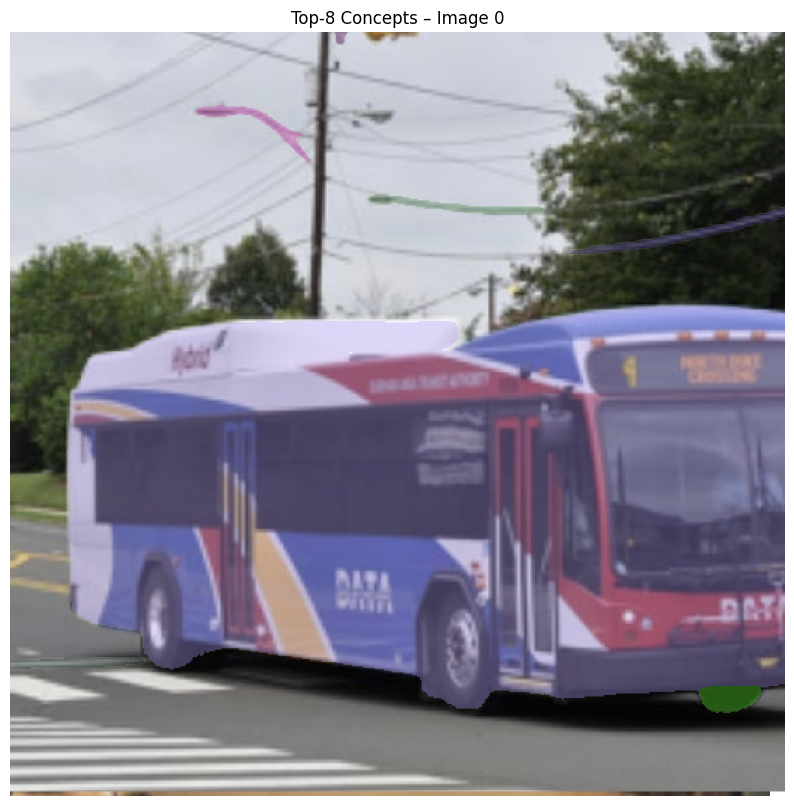

[Image 1] Top-8 concepts : [10, 41, 24, 18, 26, 77, 80, 53]


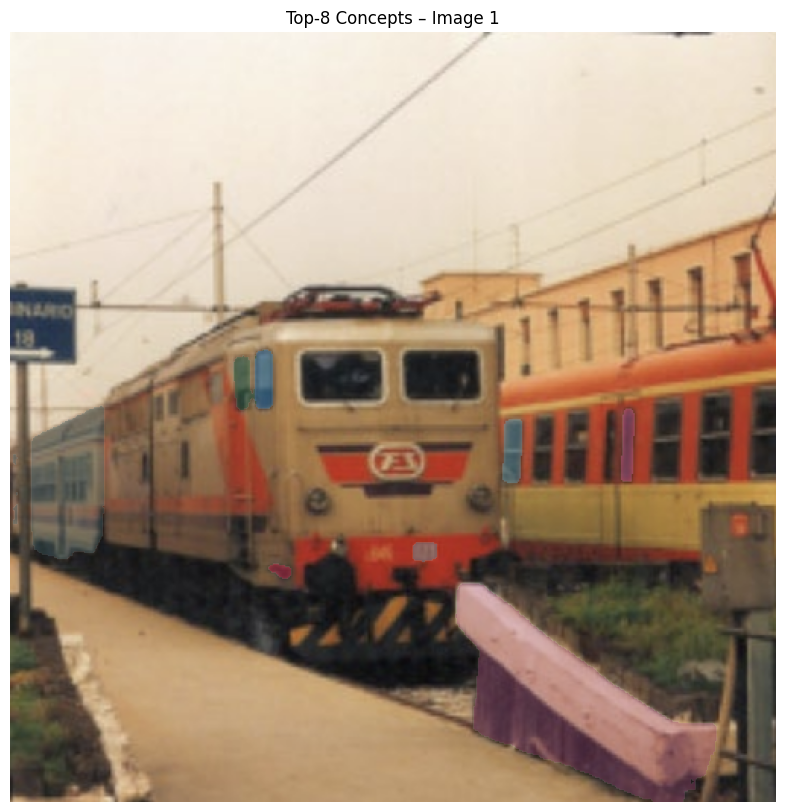

[Image 2] Top-8 concepts : [23, 28, 8, 3, 4, 14, 29, 30]


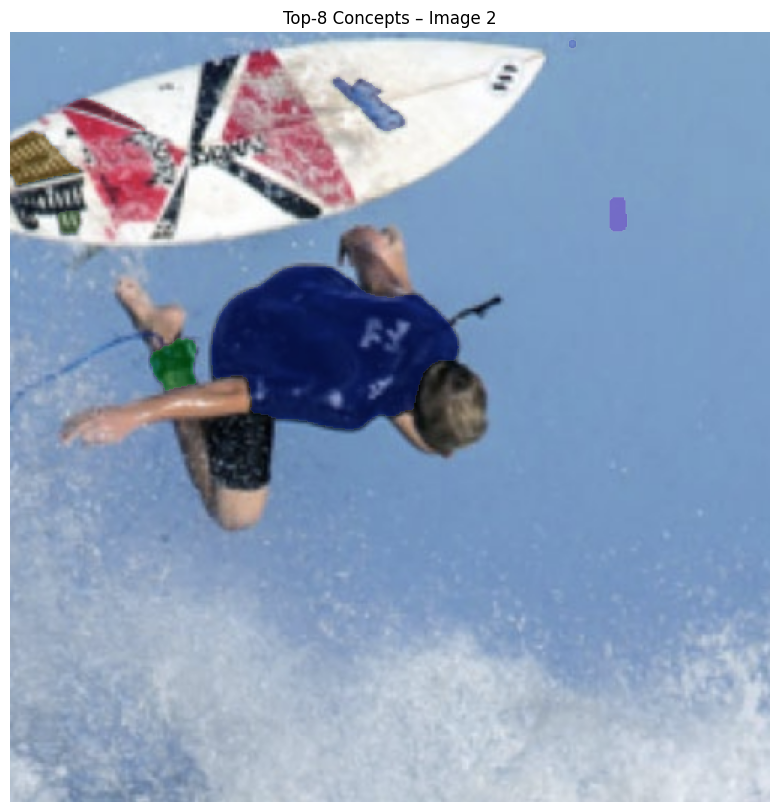

[Image 3] Top-8 concepts : [22, 17, 26, 13, 19, 9, 7, 21]


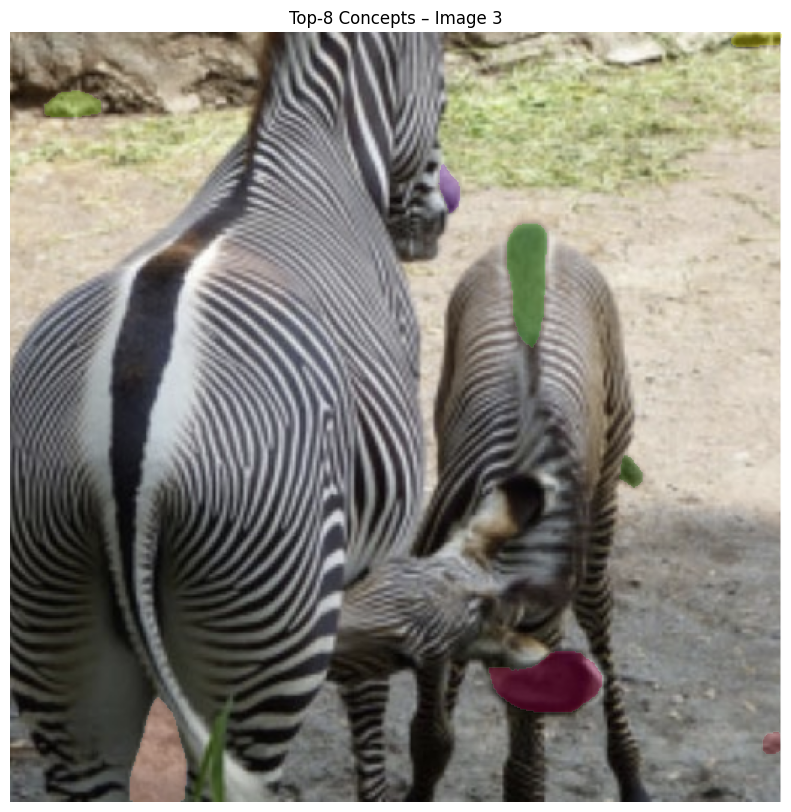

In [23]:
top_k_concepts = 8  # nombre de concepts à afficher par image

for img_idx in range(len(images)):
    # Récupérer les Shapley values pour cette image
    shap_values = all_shapley_values[img_idx]

    # Indices des k concepts les plus importants
    _, topk_indices = torch.topk(shap_values, top_k_concepts)
    topk_indices = topk_indices.tolist()

    print(f"[Image {img_idx}] Top-{top_k_concepts} concepts :", topk_indices)

    # Récupérer les masques correspondants
    masks_shapley = [masks[img_idx][i] for i in topk_indices]  # liste de dictionnaires (chacun avec 'segmentation')

    # Afficher l’image et les masques superposés
    plt.figure(figsize=(10, 10))
    plt.imshow(images[img_idx])
    show_anns(masks_shapley)
    plt.axis('off')
    plt.title(f"Top-{top_k_concepts} Concepts – Image {img_idx}")
    plt.show()


In [24]:
def show_masked_pixels(image, masks_subset, title="Masques SHAP (top-k)"):
    """
    Affiche l'image en ne montrant que les pixels activés par les masques sélectionnés.

    Args:
        image (np.ndarray): Image RGB d'origine (H x W x 3)
        masks_subset (list of np.ndarray): Masques binaires (H x W), booléens ou 0/1
        title (str): Titre du plot
    """
    if not masks_subset:
        print("Aucun masque à afficher.")
        return

    # Forcer tous les masques à être des booléens de même taille
    masks_subset = [np.array(mask, dtype=bool) for mask in masks_subset]

    # Fusionner les masques
    combined_mask = np.zeros_like(masks_subset[0], dtype=bool)
    for mask in masks_subset:
        combined_mask |= mask

    # Appliquer le masque sur l’image
    masked_image = image.copy()
    masked_image[~combined_mask] = 0  # Mettre à noir tout ce qui n'est pas masqué

    plt.imshow(masked_image)
    plt.title(title)
    plt.axis("off")
    plt.show()


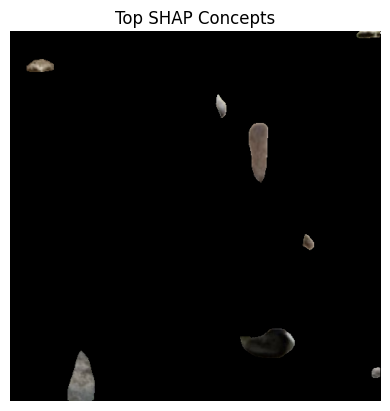

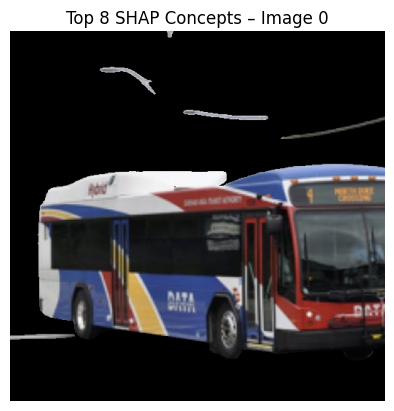

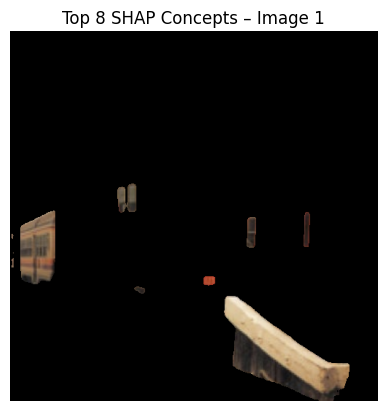

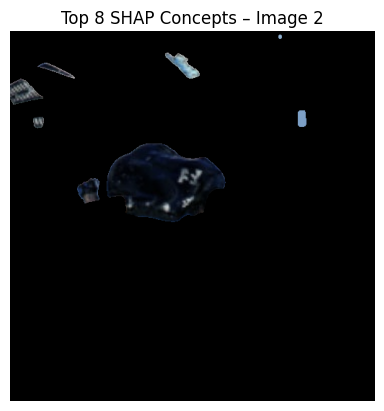

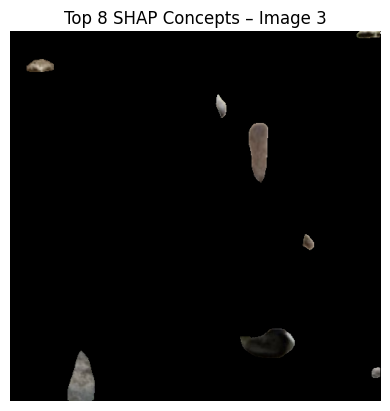

In [25]:
binary_masks = [m['segmentation'] for m in masks_shapley]
show_masked_pixels(image, binary_masks, title="Top SHAP Concepts")

for img_idx in range(len(images)):
    shap_values = all_shapley_values[img_idx]
    image = images[img_idx]

    # Récupérer les top-k concepts
    _, topk_indices = torch.topk(shap_values, top_k_concepts)
    topk_indices = topk_indices.tolist()

    masks_shapley = [masks[img_idx][i] for i in topk_indices]
    binary_masks = [m['segmentation'] for m in masks_shapley]

    # Affichage
    show_masked_pixels(image, binary_masks, title=f"Top {top_k_concepts} SHAP Concepts – Image {img_idx}")


**Evaluation metric**

Insertion and Deletion scheme

In [26]:
from sklearn.metrics import auc
import numpy as np

''' # --- Étape 1 : Ordonner les concepts par importance SHAP ---
shap_np = shapley_values.detach().cpu().numpy()
sorted_idx = np.argsort(-shap_np)  # du + important au -
sorted_masks = [concepts[i] for i in sorted_idx]  # concepts = liste de masques binaires HxW
 '''

# --- Étape 2 : Fonction insertion/deletion ---
def apply_concepts(img, masks, model, normalize, mode='insertion', image_class=None):
    """
    img: image originale (numpy RGB)
    masks: liste de masques binaires (H x W), ordonnés par importance
    """
    H, W, C = img.shape
    base = np.zeros_like(img) if mode == 'insertion' else img.copy()
    step_preds = []

    # Créer les masques cumulés : cumul logique des top-k masques
    cumulative_masks = []
    current_mask = np.zeros((H, W), dtype=bool)
    for mask in masks:
        current_mask = np.logical_or(current_mask, mask)
        cumulative_masks.append(current_mask.copy())

    for cum_mask in cumulative_masks:
        mask = cum_mask[:, :, None]  # shape (H, W, 1)
        if mode == 'insertion':
            applied = np.where(mask, img, 0)
        elif mode == 'deletion':
            applied = np.where(mask, 0, img)

        with torch.no_grad():
            inp = torch.from_numpy(applied).permute(2, 0, 1).float() / 255.
            inp = normalize(inp).unsqueeze(0).to("cuda")
            pred = model(inp)
            if image_class is None:
                image_class = pred.argmax().item()
            proba = torch.softmax(pred, dim=1)[0, image_class].item()

        step_preds.append(proba)

    return step_preds


# --- Étape 3 : AUC ---
def compute_auc(step_preds):
    x = np.linspace(0, 1, len(step_preds))
    return auc(x, step_preds)


''' # --- Étape 4 : Calcule les scores ---
# Choisir la classe prédite initialement
with torch.no_grad():
    inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
    inp = normalize(inp).unsqueeze(0).to("cuda")
    image_class = target_model(inp).argmax().item()

    print("Image class:", image_class)
    # ou utliser predicted_idx '''


' # --- Étape 4 : Calcule les scores ---\n# Choisir la classe prédite initialement\nwith torch.no_grad():\n    inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.\n    inp = normalize(inp).unsqueeze(0).to("cuda")\n    image_class = target_model(inp).argmax().item()\n\n    print("Image class:", image_class)\n    # ou utliser predicted_idx '

In [27]:
def compute_auc_normalized(step_preds, original_proba):
    preds = np.array(step_preds)
    preds[preds >= original_proba] = original_proba
    preds = preds / original_proba
    x = np.linspace(0, 100, len(preds))
    return auc(x, preds)

[Image 0] Insertion AUC: 75.7745 | Deletion AUC: 26.5020


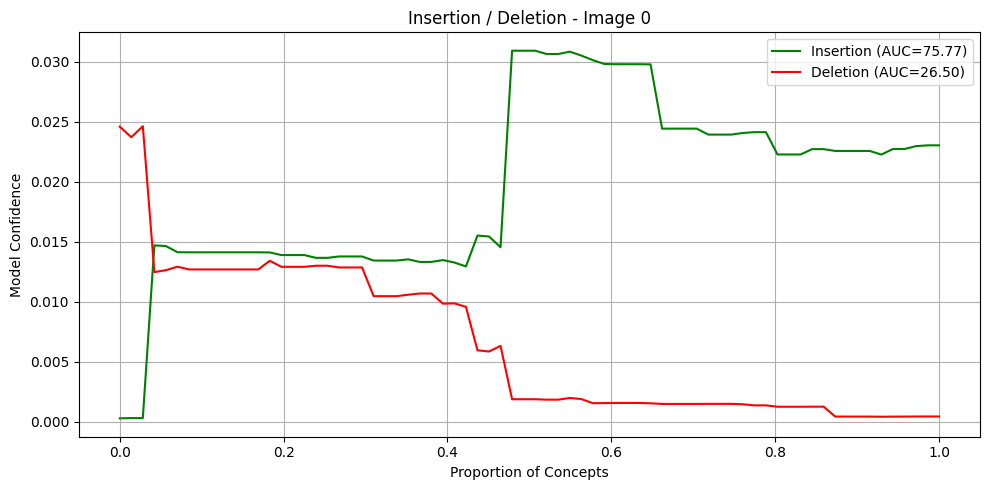

[Image 1] Insertion AUC: 70.9392 | Deletion AUC: 38.7120


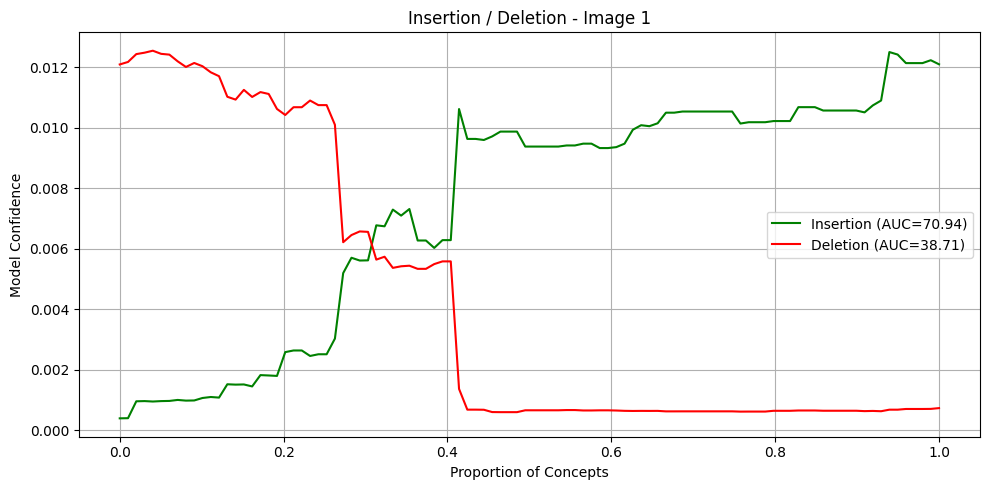

[Image 2] Insertion AUC: 30.9428 | Deletion AUC: 71.3961


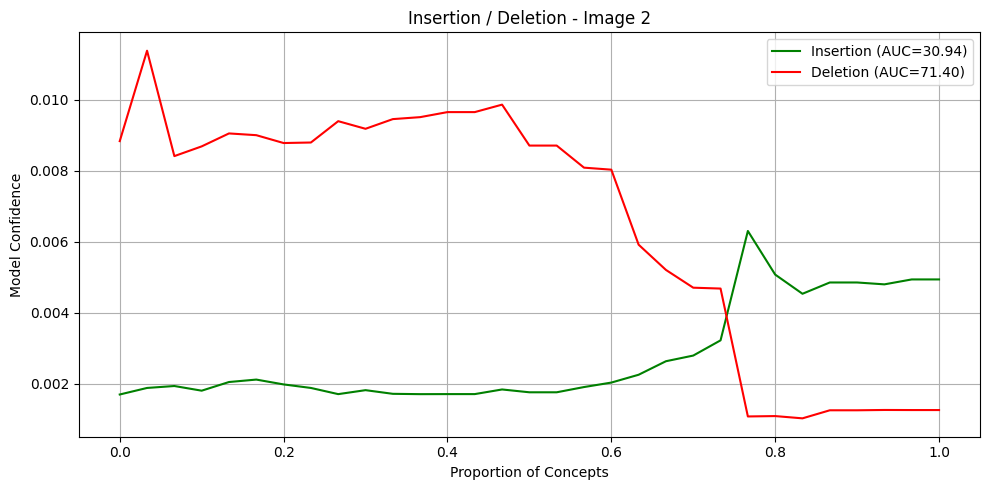

[Image 3] Insertion AUC: 61.7059 | Deletion AUC: 46.9121


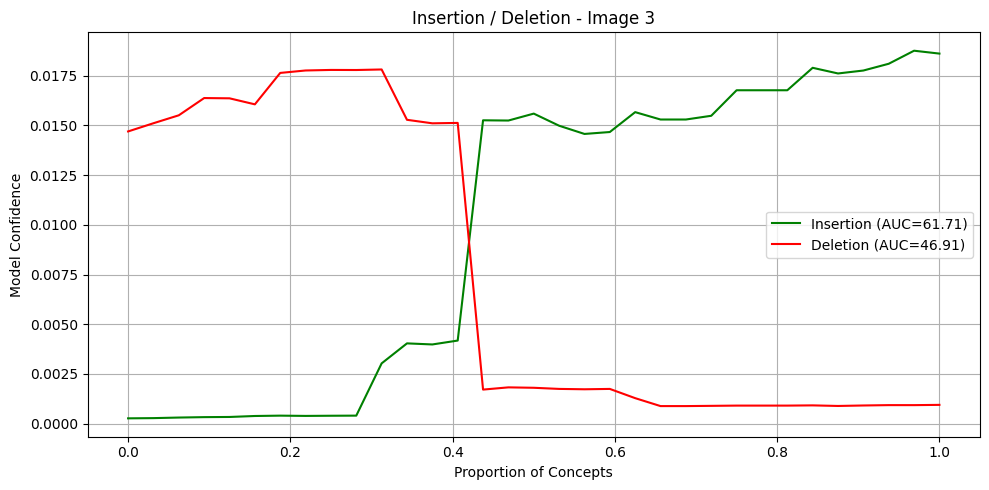

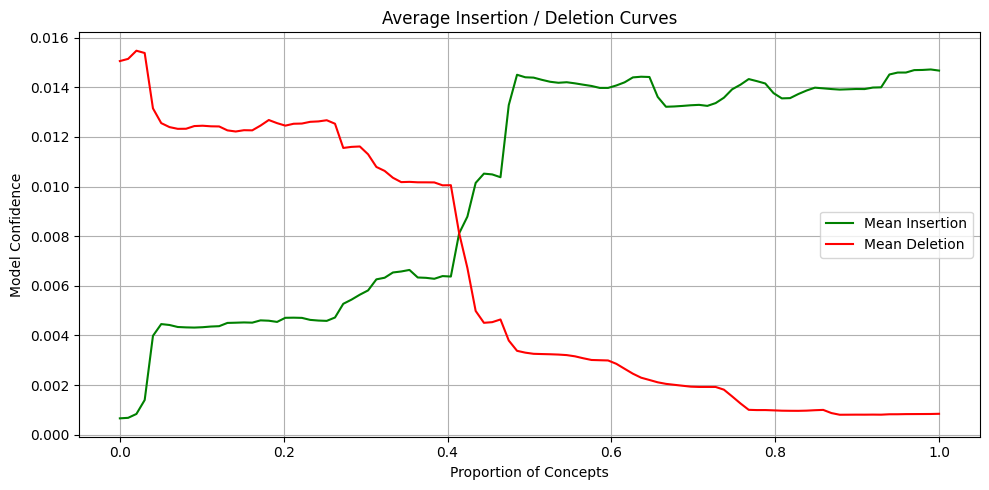


Mean Insertion AUC: 59.8406
Mean Deletion AUC: 45.8806


In [32]:


insertion_aucs = []
deletion_aucs = []

all_insertion_scores = []
all_deletion_scores = []

# Taille fixe de points pour toutes les courbes
n_points = 100
x_target = np.linspace(0, 1, n_points)

# fonction pour interpoler les courbes entre elles et avoir le même nombre final de points
def resample_curve(curve):
    x_original = np.linspace(0, 1, len(curve))
    interpolator = interp1d(x_original, curve, kind='linear')
    return interpolator(x_target)

for img_idx, (image, image_class) in enumerate(zip(images, predicted_indices)):
    # Valeurs de Shapley pour l'image courante
    shapley_values = all_shapley_values[img_idx]
    shap_np = shapley_values.detach().cpu().numpy()

    # Récupérer les masques binaires HxW pour cette image depuis masks
    concepts = [m["segmentation"] for m in masks[img_idx]]  # masks = liste de listes de dicts

    # Trier les concepts du + important au -
    sorted_idx = np.argsort(-shap_np)
    sorted_masks = [concepts[i] for i in sorted_idx]

    # Appliquer insertion / suppression
    insertion_scores = apply_concepts(image, sorted_masks, target_model, normalize, mode='insertion', image_class=image_class)
    deletion_scores = apply_concepts(image, sorted_masks, target_model, normalize, mode='deletion', image_class=image_class)

    # Prédiction originale
    with torch.no_grad():
        inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
        inp = normalize(inp).unsqueeze(0).to("cuda")
        original_proba = torch.softmax(target_model(inp), dim=1)[0, image_class].item()

    # AUCs
    insertion_auc = compute_auc_normalized(insertion_scores, original_proba)
    deletion_auc = compute_auc_normalized(deletion_scores, original_proba)

    insertion_aucs.append(insertion_auc)
    deletion_aucs.append(deletion_auc)
    all_insertion_scores.append(resample_curve(insertion_scores))
    all_deletion_scores.append(resample_curve(deletion_scores))

    print(f"[Image {img_idx}] Insertion AUC: {insertion_auc:.4f} | Deletion AUC: {deletion_auc:.4f}")


    # X-axis = pourcentage de régions insérées / supprimées
    x = np.linspace(0, 1, len(insertion_scores))

    plt.figure(figsize=(10, 5))

    # Courbe Insertion
    plt.plot(x, insertion_scores, label=f'Insertion (AUC={insertion_auc:.2f})', color='green')
    # Courbe Deletion
    plt.plot(x, deletion_scores, label=f'Deletion (AUC={deletion_auc:.2f})', color='red')

    # Ajout titres et légende
    plt.title(f"Insertion / Deletion - Image {img_idx}")
    plt.xlabel("Proportion of Concepts")
    plt.ylabel("Model Confidence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Affichage
    plt.show()

# Convertion des listes en array
insertion_matrix = np.array(all_insertion_scores)
deletion_matrix = np.array(all_deletion_scores)

# Calcute des courbes moyennes
mean_insertion = insertion_matrix.mean(axis=0)
mean_deletion = deletion_matrix.mean(axis=0)
x = np.linspace(0, 1, len(mean_insertion))

# Plot les coubes moyennes
plt.figure(figsize=(10, 5))
plt.plot(x, mean_insertion, label='Mean Insertion', color='green')
plt.plot(x, mean_deletion, label='Mean Deletion', color='red')
plt.title("Average Insertion / Deletion Curves")
plt.xlabel("Proportion of Concepts")
plt.ylabel("Model Confidence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC moyens
print(f"\nMean Insertion AUC: {np.mean(insertion_aucs):.4f}")
print(f"Mean Deletion AUC: {np.mean(deletion_aucs):.4f}")
